# HW 2 Multimodal Machine Learning for Emotion Recognition

- main with sub notebooks
    1. audio (acoustic) 
    2. text (lexical) 
    3. visual (this notebook)
    
- `%load` and `%run` with [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-load): This allows us to get code from another notebook

In [3]:
main_notebook = 'main.ipynb'

In [4]:
# %load main_notebook
main.ipynb

In [5]:
%run 'main.ipynb'

# TODOS

## Load Data

- If video, the original video will be a 3D with a T dimension. This specific case, we have a 2D of (T, 2048) which is based on the ResNet encoder

In [8]:
# visual_features_paths

In [9]:
ys = features_with_y.loc[0:, 'emotion_labels']
# ys

## 1. Reduce Temporal Dimension

In [10]:
def reduce_temporal_dimension(visual_features_paths, ys):
    """Reduce from 2D to 1D by removing the time dimension
    
    visual_features_paths -- list
    
    Return 
    reduced shapes of each input -- list
    """
    reduced_visual_features = []
    true_labels = []
    
    for row in range(len(visual_features_paths)):
        # print(ys[row])
        # print("Current path with files is: ", visual_features_path)
        path_exists = os.path.exists(visual_features_paths[row])
        # print(path_exists)
        if path_exists == True:
            # print("Current path with files is: ", visual_features_path)
            load_visual_features_file = np.load(visual_features_paths[row])
            # print("  Original Shape: ", np.shape(load_visual_features_file))
            resampled_visual = np.mean(load_visual_features_file, axis=0)
            reduced_visual_features.append(resampled_visual)
            # print("  Reduced shape: ", np.shape(resampled_visual))
            # print()
            true_labels.append(ys[row])
        else:
            # print()
            
            # print("\nCANNOT find current path: ", visual_features_paths[row])
            # print("DoNOT include", ys[row])
            pass
    return reduced_visual_features, true_labels

In [11]:
reduced_temporal_dimensions, true_labels = reduce_temporal_dimension(visual_features_paths, ys)
np.shape(reduced_temporal_dimensions), np.shape(true_labels)

((1003, 2048), (1003,))

## 2. Perform a 4-Class Emotion Classification

See my [HW 2 Notes](https://detraviousjbrinkley.notion.site/HW-2-Multimodal-Machine-Learning-for-Emotion-Recognition-4967e03039b04f20907996de25f6068a) for more details on 
1. Support Vector Machine (SVM)
2. Support Vector Classification (SVC)
3. Note that LinearSVC does not accept parameter kernel, as this is assumed to be linear per the [SVM documentation](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification)

### Split Data
`train_test_split` from https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [12]:
X_train, X_test, y_train, y_test = train_test_split(reduced_temporal_dimensions, true_labels, test_size=0.7, random_state=42)
total_X = len(X_train) + len(X_test)
total_Y = len(y_train) + len(y_test)
len(X_train), len(X_test), len(y_train), len(y_test), total_X, total_Y

(300, 703, 300, 703, 1003, 1003)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.7, random_state=42) # 0.25 x 0.8 = 0.2
total_X = len(X_train) + len(X_val)
total_Y = len(y_train) + len(y_val)
len(X_train), len(X_val), len(y_train), len(y_val), total_X, total_Y

(90, 210, 90, 210, 300, 300)

### Without Hyper-Parameter Tuning

- `score()` uses coefficient of determination. The coefficient will have a value in the range [0, 1], where 0 implies that we cannot predict the target output correctly, while a value of 1 implies we can perfectly predict the output with no error. Read more: (1) https://pyimagesearch.com/2021/05/17/introduction-to-hyperparameter-tuning-with-scikit-learn-and-python/ or (2) https://stattrek.com/statistics/dictionary?definition=coefficient_of_determination

- Output of `score()` shows that we obtain a coefficient of determination value of 1, meaning that 100% of the variance in Y (our 4 different emotion classes) is predictable based on X (our **visual** feature values)

[INFO] training our linear support vector classification estimator
[INFO] evaluating...
1.0
[INFO] classification on TEST...


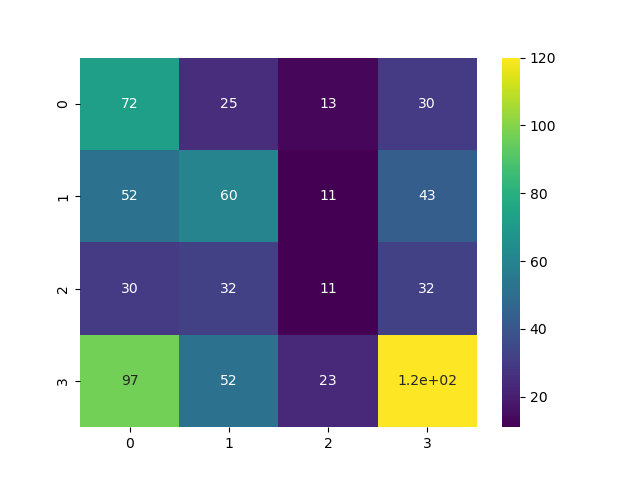

In [46]:
print("[INFO] training our linear support vector classification estimator")

# initialize the LinearSVC() estimator 
classification_estimator = svm.LinearSVC()

# train the model without hyperparameter tuning
train_without_hp = classification_estimator.fit(X_train, y_train)

print("[INFO] evaluating...")

# evaluate the model without hyperparameter tuning model
print(train_without_hp.score(X_train, y_train))
# print(train_without_hp.best_score)

print("[INFO] classification on TEST...")
# make a prediction (returns a list of 0 - 4 values)
y_pred_without_hp = train_without_hp.predict(X_test)
# show true labels and predictions
cm = confusion_matrix(y_test, y_pred_without_hp)
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

In [51]:
print(classification_report(y_test, y_pred_without_hp))

              precision    recall  f1-score   support

           0       0.29      0.51      0.37       140
           1       0.36      0.36      0.36       166
           2       0.19      0.10      0.13       105
           3       0.53      0.41      0.46       292

    accuracy                           0.37       703
   macro avg       0.34      0.35      0.33       703
weighted avg       0.39      0.37      0.37       703



### With Hyper-Parameter Tuning

- Search hyper-parameters of the `LinearSVC()` estimator and find the optimal values
- Output of `score` shows no difference compared to without hyper-parameter tuning. What does this mean?

In [24]:
# get all hyper-parameters of the LinearSVC() estimator
svm.LinearSVC().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [26]:
# initialize the LinearSVC() estimator 
classification_estimator = svm.LinearSVC()

# define the hyper-parameters to perform the grid search over
param_grid = {
    'C': [0.01, 0.1, 10, 100], 
    # 'class_weight': [1],
    # 'dual':,
    'fit_intercept': [True, False],
    # 'intercept_scaling':,
    'loss': ['hinge', 'squared_hinge'],
    # 'max_iter':,
     # 'multi_class': [1],
    # 'penalty': ['l1', 'l2'],
    'penalty': ['l2'],
    # 'random_state':,
    # 'tol': , 
    # 'verbose':    
}

print("[INFO] grid searching over the hyper-parameters...")
# perform grid search with our estimator, hyper-parameters, cross-validation
linear_classification = GridSearchCV(classification_estimator, param_grid=param_grid, cv=10)
linear_classification

[INFO] grid searching over the hyper-parameters...


GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 10, 100],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l2']})

In [28]:
# train the model with hyperparameter tuning
train_with_hp = linear_classification.fit(X_train, y_train)
train_with_hp

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 10, 100],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l2']})

In [38]:
print("[INFO] the best hyper-parameters are...")
# show the best estimator
print(train_with_hp.best_params_)

print("\n[INFO] the coefficient of determination is...")
# evaluate the best model
print(train_with_hp.score(X_train, y_train))

print("\n[INFO] the best score...")
# show the best score
print(train_with_hp.best_score_)

[INFO] the best hyper-parameters are...
{'C': 0.01, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2'}

[INFO] the coefficient of determination is...
1.0

[INFO] the best score...
0.3666666666666667


[INFO] classification on TEST...


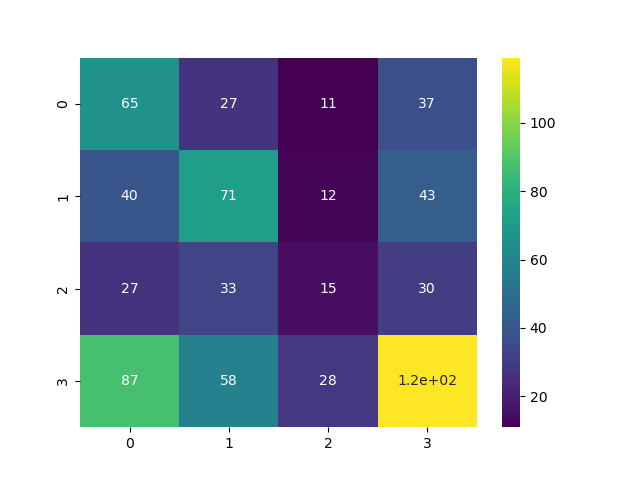

In [48]:
print("[INFO] classification on TEST...")
# make a prediction (returns a list of 0 - 4 values)
y_pred_with_hp = train_with_hp.predict(X_test)
# show true labels and predictions
cm = confusion_matrix(y_test, y_pred_with_hp)
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

In [50]:
print(classification_report(y_test, y_pred_with_hp))

              precision    recall  f1-score   support

           0       0.30      0.46      0.36       140
           1       0.38      0.43      0.40       166
           2       0.23      0.14      0.18       105
           3       0.52      0.41      0.46       292

    accuracy                           0.38       703
   macro avg       0.35      0.36      0.35       703
weighted avg       0.40      0.38      0.38       703

